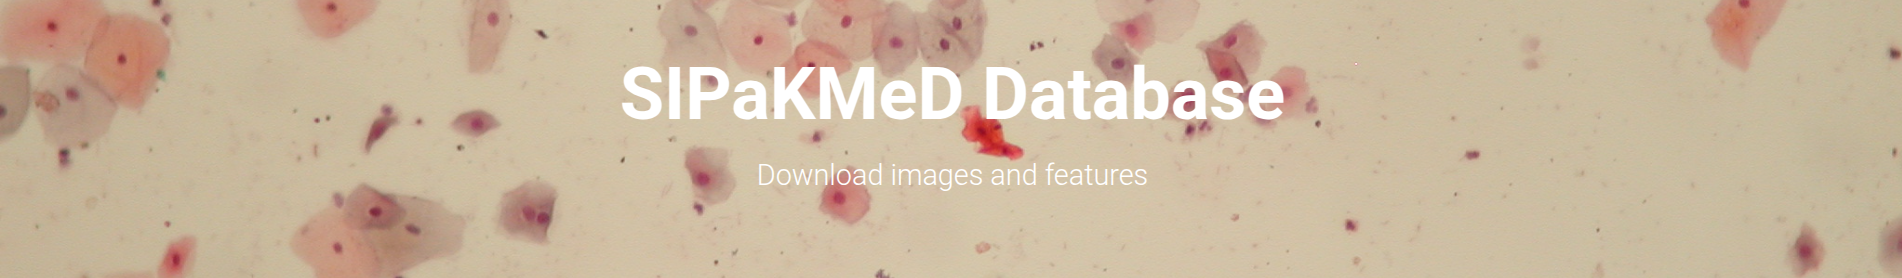

The SIPaKMeD database is publicly available and it can be used for experimental purposes with the request to cite the following paper:

**Marina E. Plissiti, Panagiotis Dimitrakopoulos, Giorgos Sfikas, Christophoros Nikou, Olga Krikoni, Antonia Charchanti, SIPAKMED: A new dataset for feature and image based classification of normal and pathological cervical cells in Pap smear images, IEEE International Conference on Image Processing (ICIP) 2018, Athens, Greece, 7-10 October 2018.**

In [4]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

sys.path.append(os.path.abspath('..'))

from Preprocessing.preprocessing import split_data
import tensorflow as tf
from Training.eval import evaluate_model
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm

2025-03-12 11:29:28.889526: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 11:29:28.892883: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 11:29:28.937022: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 11:29:28.992465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741778969.046774 1786728 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741778969.06

**01. Load & Explore the Data**

In [5]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import cv2
import numpy as np

DATASET_PATH = "../Datasets/SIPaKMeD"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
OUTPUT_FEATURES_PATH = "../Feature_Extraction"

def load_dataset(dataset_path):
    """
    Loads the dataset by scanning directories for `.bmp` images.
    Returns:
    - file_paths: Dict with class names as keys and list of image paths as values
    - class_counts: Dict with class names as keys and count of images as values
    """
    file_paths = {}
    class_counts = {}

    for class_name in sorted(os.listdir(dataset_path)):  
        class_dir = os.path.join(dataset_path, class_name, "CROPPED")
        if os.path.isdir(class_dir):
            bmp_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(".bmp")]
            file_paths[class_name] = bmp_files
            class_counts[class_name] = len(bmp_files)

    return file_paths, class_counts

def visualize_class_distribution(class_counts):
    """
    Plots a bar chart showing class distribution.
    """
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.title("Class Distribution in SIPaKMeD Dataset")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=20)
    plt.show()
    
    

def plot_sample_images(file_paths, num_samples=5):
    """
    Plots sample images from each class.
    """
    fig, axes = plt.subplots(len(file_paths), num_samples, figsize=(num_samples * 2, len(file_paths) * 2))

    for i, (class_name, paths) in enumerate(file_paths.items()):
        sample_paths = np.random.choice(paths, num_samples, replace=False) if len(paths) >= num_samples else paths
        for j, img_path in enumerate(sample_paths):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(class_name, fontsize=12, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


Class Counts: {'im_Dyskeratotic': 813, 'im_Koilocytotic': 825, 'im_Metaplastic': 793, 'im_Parabasal': 787, 'im_Superficial-Intermediate': 831}


/tmp/ipykernel_1786728/3771611738.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


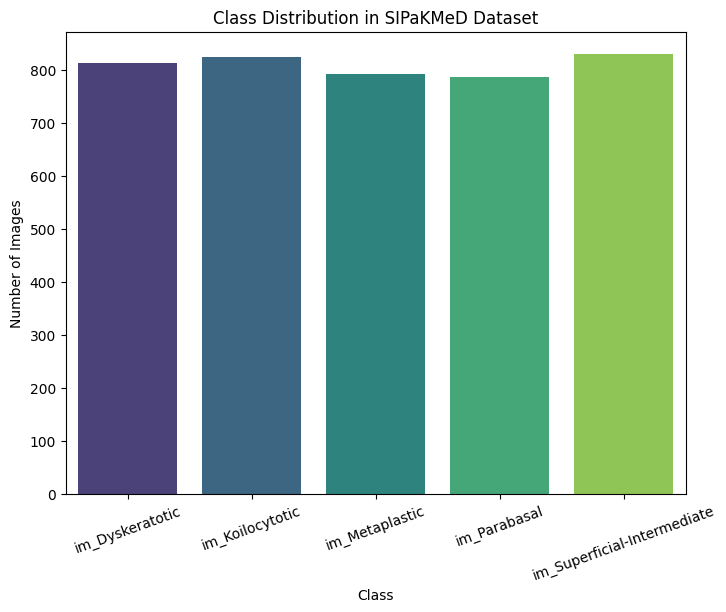

In [6]:
file_paths, class_counts = load_dataset(DATASET_PATH)
print(f"Class Counts: {class_counts}")
visualize_class_distribution(class_counts)


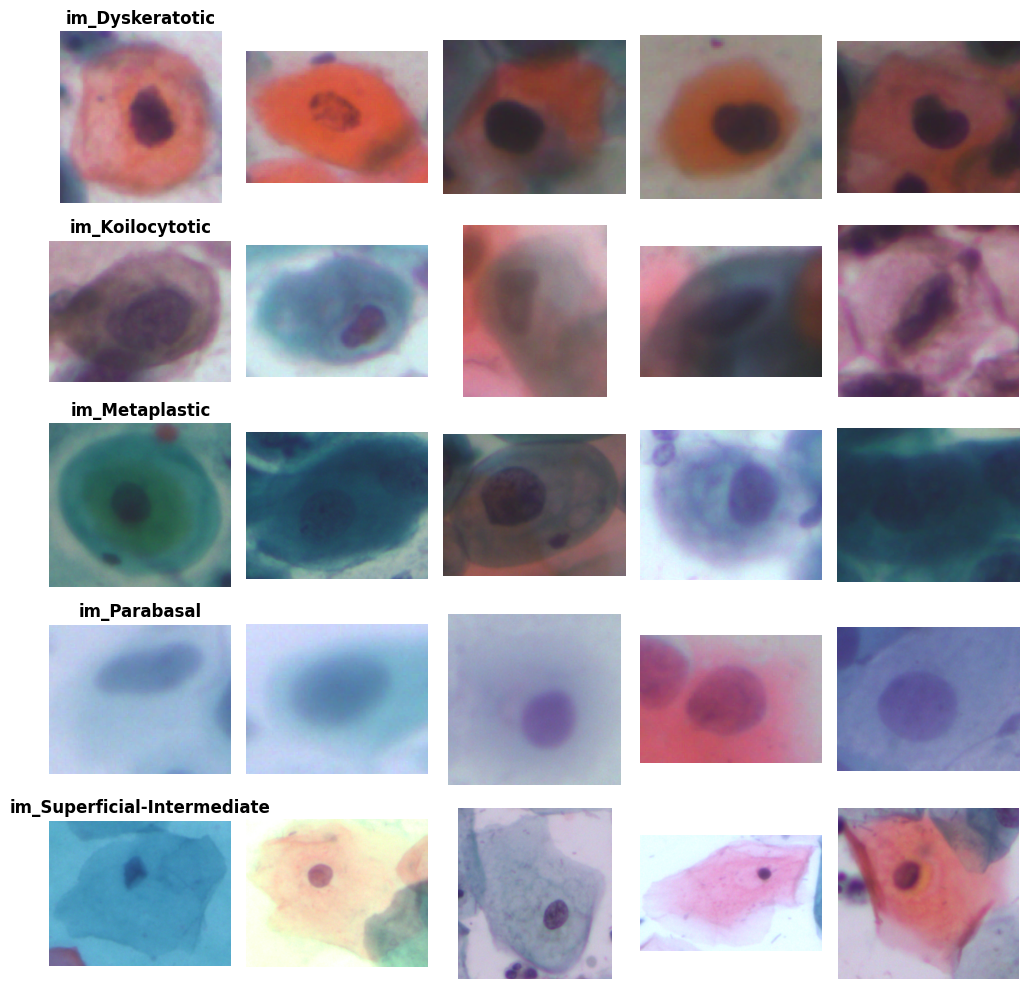

In [7]:
plot_sample_images(file_paths, num_samples=5)

**02. Data Preprocessing.**

* split data

In [8]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


RAW_DATASET_PATH = "../Datasets/SIPaKMeD"
PREPROCESSED_PATH = "../Datasets/SIPaKMeD/Preprocessed"

splits = ["train", "cal", "val", "test"]
for split in splits:
    for class_name in os.listdir(RAW_DATASET_PATH):
        class_dir = os.path.join(RAW_DATASET_PATH, class_name, "CROPPED")
        if os.path.isdir(class_dir):
            os.makedirs(os.path.join(PREPROCESSED_PATH, split, class_name), exist_ok=True)
            

def clear_directory(directory):
    """Deletes all files in a given directory while preserving the structure."""
    if os.path.exists(directory):
        for class_name in os.listdir(directory):
            class_path = os.path.join(directory, class_name)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    file_path = os.path.join(class_path, file)
                    os.remove(file_path)


def split_data(train_ratio=0.7, cal_ratio=0.1, val_ratio=0.1, test_ratio=0.1):
    """
    Splits dataset into train, cal, val, and test sets correctly, ensuring 
    proper distribution for each class.
    """
    
    for split in ["train", "cal", "val", "test"]:
        clear_directory(os.path.join(PREPROCESSED_PATH, split))

    total_images = 0

    for class_name in os.listdir(RAW_DATASET_PATH):
        class_dir = os.path.join(RAW_DATASET_PATH, class_name, "CROPPED")
        if not os.path.isdir(class_dir):
            continue

        images = [img for img in os.listdir(class_dir) if img.endswith(".bmp")]
        random.shuffle(images)
        
        class_total = len(images)
        total_images += class_total

        print(f"Class: {class_name} → Total images: {class_total}")

        if class_total == 0:
            print(f"Warning: No images found for class {class_name}. Skipping.")
            continue

        train_idx = int(class_total * train_ratio)
        cal_idx = train_idx + int(class_total * cal_ratio)
        val_idx = cal_idx + int(class_total * val_ratio)

        for i, img in enumerate(images):
            src = os.path.join(class_dir, img)
            if i < train_idx:
                dst = os.path.join(PREPROCESSED_PATH, "train", class_name, img)
            elif i < cal_idx:
                dst = os.path.join(PREPROCESSED_PATH, "cal", class_name, img)
            elif i < val_idx:
                dst = os.path.join(PREPROCESSED_PATH, "val", class_name, img)
            else:
                dst = os.path.join(PREPROCESSED_PATH, "test", class_name, img)
            shutil.copy(src, dst)

    print("Dataset split into train, cal, val, and test sets successfully.")
    print(f"Total images processed: {total_images}")


def load_data(img_size=(224, 224), batch_size=32, use_val=True):
    """
    Loads dataset with augmentation for training and normalization for other sets.
    """
    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    datagen = ImageDataGenerator(rescale=1./255)

    train_data = datagen_train.flow_from_directory(
        PREPROCESSED_PATH + "/train", 
        target_size=img_size, 
        batch_size=batch_size, 
        class_mode="categorical"
    )

    cal_data = datagen.flow_from_directory(
        PREPROCESSED_PATH + "/cal", 
        target_size=img_size, 
        batch_size=batch_size, 
        class_mode="categorical"
    )

    val_data = None
    if use_val:
        val_data = datagen.flow_from_directory(
            PREPROCESSED_PATH + "/val", 
            target_size=img_size, 
            batch_size=batch_size, 
            class_mode="categorical"
        )

    test_data = datagen.flow_from_directory(
        PREPROCESSED_PATH + "/test", 
        target_size=img_size, 
        batch_size=batch_size, 
        class_mode="categorical", 
        shuffle=False
    )

    return train_data, cal_data, val_data, test_data

In [18]:
split_data(train_ratio=0.75, cal_ratio=0.1, test_ratio=0.15)
train_data, cal_data, val_data, test_data = load_data(use_val=True)
print(f"Training samples: {train_data.samples}")
print(f"Calibration samples: {cal_data.samples}")
print(f"Validation samples: {val_data.samples if val_data else 'None'}")
print(f"Test samples: {test_data.samples}")

Class: im_Dyskeratotic → Total images: 813
Class: im_Parabasal → Total images: 787
Class: im_Superficial-Intermediate → Total images: 831
Class: im_Koilocytotic → Total images: 825
Class: im_Metaplastic → Total images: 793
Dataset split into train, cal, val, and test sets successfully.
Total images processed: 4049
Found 3034 images belonging to 5 classes.
Found 403 images belonging to 5 classes.
Found 403 images belonging to 5 classes.
Found 209 images belonging to 5 classes.
Training samples: 3034
Calibration samples: 403
Validation samples: 403
Test samples: 209


**03. Feature Extraction**

* 3.1 Models for extraction

In [9]:
import keras
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

def VGG_Lite(input_shape=(224, 224, 3)):
    """
    VGG Lite model with 5 convolutional layers and 2 dense layers.
    """
    
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape= input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=5, activation='sigmoid')) 

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [10]:
from multiprocessing import Pool, cpu_count, Manager

NUM_PROCESSES = min(5, cpu_count())


def load_data_generator(split):
    """Loads dataset split inside each worker process ."""
    datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
        PREPROCESSED_PATH + f"/{split}",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="sparse",
        shuffle=False
    )




def create_feature_extractor(base_model_name):
    """Creates a feature extractor inside the worker process."""
    if base_model_name == "ResNet50":
        base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == "DenseNet121":
        base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == "VGG_Lite":
        base_model = VGG_Lite(input_shape=(224, 224, 3))
    else:
        raise ValueError("Invalid base model. Choose 'ResNet50', 'DenseNet121', or 'VGG_Lite'.")

    x = GlobalAveragePooling2D()(base_model.output)
    model = Model(inputs=base_model.input, outputs=x)
    return model


def load_data_generator(split):
    """Loads dataset split inside each worker process (avoids pickling issue)."""
    datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
        PREPROCESSED_PATH + f"/{split}",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="sparse",
        shuffle=False
    )


def extract_features(args):
    """
    Extracts features inside the worker process to avoid pickling issues.
    
    Parameters:
    - model_name: Name of the model ("ResNet50", "DenseNet121", "VGG_Lite")
    - split_name: Dataset split ("train", "cal", "val", "test")
    - output_path: Directory to save extracted features
    """
    model_name, split_name, output_path = args

    print(f"Starting feature extraction: {model_name} | {split_name}")  

    model = create_feature_extractor(model_name)
    data_generator = load_data_generator(split_name)

    features = []
    labels = []

    for batch_images, batch_labels in tqdm(data_generator, desc=f"Extracting {model_name} {split_name}"):
        batch_features = model.predict(batch_images, verbose=0)
        features.append(batch_features)
        labels.append(batch_labels)

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    feature_path = os.path.join(output_path, f"{model_name}_{split_name}_features.npy")
    label_path = os.path.join(output_path, f"{split_name}_labels.npy")

    np.save(feature_path, features)
    np.save(label_path, labels)

    print(f"✅ Completed: {model_name} | {split_name} | Features: {features.shape} | Labels: {labels.shape}")

def process_feature_extraction(models_names=["ResNet50", "DenseNet121", "VGG_Lite"]):
    os.makedirs(OUTPUT_FEATURES_PATH, exist_ok=True)
    tasks = [
        (model_name, split, OUTPUT_FEATURES_PATH)
        for model_name in models_names
        for split in ["train", "cal", "val", "test"]
    ]
    
    print(f"📌 Total tasks to process: {len(tasks)}") 
    print(f"📌 Using {NUM_PROCESSES} parallel workers") 

    with Pool(NUM_PROCESSES) as pool, tqdm(total=len(tasks), desc="Feature Extraction Progress") as pbar:
        for _ in pool.imap_unordered(extract_features, tasks):
            pbar.update(1)

    print("\n✅ Feature extraction completed successfully!")

In [ ]:
process_feature_extraction()

📌 Total tasks to process: 12
📌 Using 5 parallel workers


Feature Extraction Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Starting feature extraction: ResNet50 | calStarting feature extraction: ResNet50 | trainStarting feature extraction: ResNet50 | valStarting feature extraction: DenseNet121 | trainStarting feature extraction: ResNet50 | test






W0000 00:00:1741779020.904735 1786728 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
W0000 00:00:1741779020.909541 1786728 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
W0000 00:00:1741779020.921035 1786728 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how

Found 403 images belonging to 5 classes.


Extracting ResNet50 cal:   0%|          | 0/13 [00:00<?, ?it/s]

Found 403 images belonging to 5 classes.


Extracting ResNet50 val:   0%|          | 0/13 [00:00<?, ?it/s]

Found 209 images belonging to 5 classes.


Extracting ResNet50 test:   0%|          | 0/7 [00:00<?, ?it/s]

Found 3034 images belonging to 5 classes.


Extracting ResNet50 train:   0%|          | 0/95 [00:00<?, ?it/s]

Found 3034 images belonging to 5 classes.


Extracting ResNet50 train:   1%|          | 1/95 [00:07<12:24,  7.92s/it]

**04. Feature visualization (PCA/t-SNE)**


- How separable the features are across classes.

- The effectiveness of ResNet50 vs. DenseNet121 in feature extraction.

- How well the extracted features preserve class structure.

In [23]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [24]:
FEATURES_PATH = "../Feature_Extraction"

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

FEATURES_PATH = "../Feature_Extraction"

def load_features_for_visualization(model_name):
    """Loads extracted features and corresponding labels."""
    X_train = np.load(os.path.join(FEATURES_PATH, f"{model_name}_train_features.npy"))

    print(f"{model_name} Feature Shape: {X_train.shape}")

    if len(X_train.shape) > 2:
        X_train = X_train.reshape(X_train.shape[0], -1)

    print(f"Flattened Feature Shape: {X_train.shape}")

    class_dirs = sorted(os.listdir(os.path.join(PREPROCESSED_PATH, "train")))
    class_counts = [len(os.listdir(os.path.join(PREPROCESSED_PATH, "train", cls))) for cls in class_dirs]

    y_train = []
    for class_index, count in enumerate(class_counts):
        y_train.extend([class_index] * count)

    y_train = np.array(y_train)

    print(f"Expected Labels Shape: {y_train.shape}")

    if len(y_train) != X_train.shape[0]:
        raise ValueError(f"Mismatch: Features ({X_train.shape[0]}) vs Labels ({len(y_train)})")

    return X_train, y_train


def load_extracted_features(model_name, split_name='train'):
    feature_path = os.path.join(FEATURES_PATH, f"{model_name}_{split_name}_features.npy")
    label_path = os.path.join(FEATURES_PATH, f"{split_name}_labels.npy")
    
    X = np.load(feature_path)
    if len(X.shape) > 2:
        X = X.reshape(X.shape[0], -1)
    y = np.load(label_path)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y
    
FEATURES_PATH = "../Feature_Extraction"

def visualize_tsne(model_name):
    """Visualizes feature distributions using t-SNE."""
    X_train = np.load(os.path.join(FEATURES_PATH, f"{model_name}_train_features.npy"))

    if len(X_train.shape) > 2:
        X_train = X_train.reshape(X_train.shape[0], -1)

    pca = PCA(n_components=50)
    X_train_pca = pca.fit_transform(X_train)

    tsne = TSNE(n_components=2, perplexity=min(50, len(X_train) // 10), random_state=42)
    X_train_tsne = tsne.fit_transform(X_train_pca)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], alpha=0.7)
    plt.title(f"t-SNE Visualization - {model_name}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()




ResNet50 Feature Shape: (3034, 7, 7, 2048)
Flattened Feature Shape: (3034, 100352)
Expected Labels Shape: (3034,)
DenseNet121 Feature Shape: (3034, 7, 7, 1024)
Flattened Feature Shape: (3034, 50176)
Expected Labels Shape: (3034,)
⚡ Applying PCA before t-SNE...
⚡ Applying t-SNE...


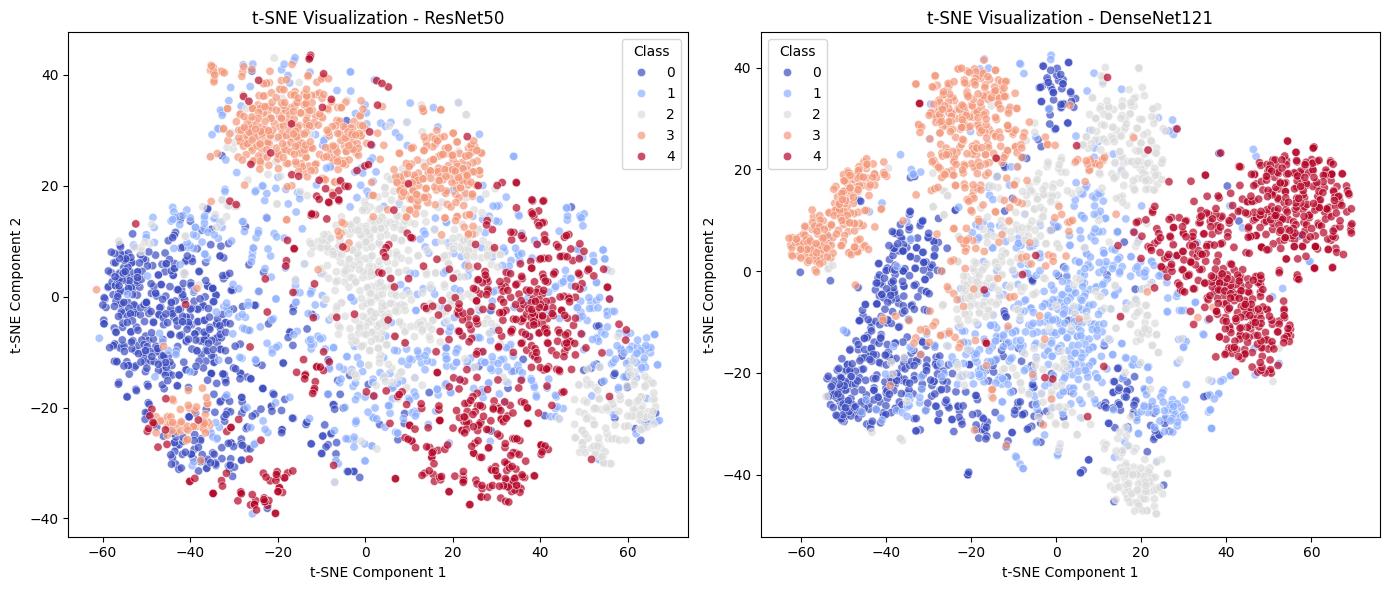

In [ ]:
for model in ["ResNet50", "DenseNet121", "VGG16"]:
    visualize_tsne(model)


In [ ]:
X_train, y_train = load_extracted_features("ResNet50", split_name="train")
X_cal, y_cal = load_extracted_features("ResNet50", split_name="cal")
X_val, y_val = load_extracted_features("ResNet50", split_name="val")
X_test, y_test = load_extracted_features("ResNet50", split_name="test")

**05. Train the Models**

`5.1 Single Determinist Network`

* Approach 1: With softmax

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report

def train_single_network(X_train, y_train, X_cal, y_cal, X_test, y_test, num_classes=5):
    """Trains a Fully Connected Network (Single Network) and evaluates it."""
    
    print("\Training Single Network...")
    model = Sequential([
        Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_cal, y_cal), verbose=1)

    return model

single_network_model = train_single_network(X_train, y_train, X_cal, y_cal, X_test, y_test)


* Approach 2: Dirichlet Distributions for Model Output

formula

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

def evidential_loss(true_labels, alpha):
    """
    Loss function for Dirichlet-based Evidential Deep Learning.
    Encourages high confidence for in-distribution data and high uncertainty for OOD.
    """
    S = tf.reduce_sum(alpha, axis=-1, keepdims=True)
    evidence = alpha - 1
    prob = alpha / S
    loss = tf.reduce_mean(tf.reduce_sum((true_labels - prob)**2, axis=1))
    return loss

def build_dirichlet_model(input_shape, num_classes):
    """Builds a neural network with Dirichlet output distribution."""
    inputs = Input(shape=input_shape)
    x = Dense(512, activation="relu")(inputs)
    x = Dense(256, activation="relu")(x)
    x = Dense(num_classes, activation="softplus")(x)
    model = Model(inputs, x)
    model.compile(optimizer="adam", loss=evidential_loss)
    return model

dirichlet_model = build_dirichlet_model(input_shape=(1024,), num_classes=5)


* Approach 3: Prior Networks for Uncertainty Estimation

formula

In [ ]:
import tensorflow.keras.backend as K

def kl_divergence(p, q):
    """Computes KL divergence between two distributions."""
    return K.sum(p * K.log(p / (q + 1e-10)), axis=-1)

def prior_network_loss(y_true, y_pred):
    """Encourages confident predictions for ID data and uncertain predictions for OOD."""
    dirichlet_params = y_pred + 1  # Ensure positivity
    alpha_0 = K.sum(dirichlet_params, axis=-1, keepdims=True)
    prob = dirichlet_params / alpha_0
    return kl_divergence(y_true, prob)

prior_model = build_dirichlet_model(input_shape=(1024,), num_classes=5)
prior_model.compile(optimizer="adam", loss=prior_network_loss)


✔ Encourages the network to distinguish ID vs. OOD confidently.
I need to create OOD sample for testing

**5.2 Train Deep Ensemble**

Approach 1: Different Models with Different Structures

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from sklearn.svm import SVC

def build_mlp(input_shape):
    model = Sequential([
        Dense(512, activation="relu", input_shape=input_shape),
        Dropout(0.5),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(5, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def build_cnn(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(512, activation="relu"),
        Dense(5, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


svm_model = SVC(kernel="linear", probability=True)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
mlp_model = build_mlp(input_shape=(1024,))
cnn_model = build_cnn(input_shape=(1024,))

ensemble_models_DS = [svm_model, rf_model, mlp_model, cnn_model]

* Approach 2: Different Models with the Same Structure

In [ ]:
def train_deep_ensemble(X_train, y_train, num_classes, num_models=5, epochs=10):
    """Trains multiple independent models and averages their predictions."""
    ensemble = []
    for i in range(num_models):
        print(f"\n🔹 Training Ensemble Model {i+1}/{num_models}...")
        
        model = build_mlp(input_shape=(X_train.shape[1],))
        model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

        ensemble.append(model)
    
    return ensemble


ensemble_models_SS = train_deep_ensemble(X_train, y_train, num_classes=5, num_models=5)

`Aggregating Ensemble Predictions`

In [ ]:
def deep_ensemble_prediction(ensemble, X_test):
    """Averages predictions from an ensemble of models."""
    preds = np.array([model.predict(X_test) for model in ensemble])
    mean_preds = preds.mean(axis=0)
    return mean_preds



**06. Monte Carlo Dropout (MCD) Inference**

In [ ]:
def monte_carlo_dropout(model, X_test, num_samples=30):
    """Performs Monte Carlo Dropout by making multiple stochastic forward passes."""
    f_model = tf.keras.Model(model.input, model.output)
    f_preds = np.array([f_model.predict(X_test, verbose=0) for _ in range(num_samples)])
    mean_preds = f_preds.mean(axis=0)
    uncertainty = f_preds.var(axis=0)
    return mean_preds, uncertainty

mcd_probs, uncertainty = monte_carlo_dropout(single_network_model, X_test, num_samples=30)
mcd_preds = np.argmax(mcd_probs, axis=1)


**07. Classification Performance Evaluation** 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(y_test, y_pred_probs, method_name):
    """Evaluates a model using Accuracy, Precision, Recall, F1-score, and AUC."""
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    auc = roc_auc_score(y_test, y_pred_probs, multi_class="ovr")

    print(f"\n🔹 {method_name} Performance:")
    print(classification_report(y_test, y_pred))

    return {"Method": method_name, "Accuracy": acc, "Precision": precision, "Recall": recall, "F1-score": f1, "AUC": auc}

single_net_results = evaluate_model(y_test, single_network_model.predict(X_test), "Single Network")
mcd_results = evaluate_model(y_test, mcd_probs, "Monte Carlo Dropout")
ensemble_results_DS = evaluate_model(y_test, deep_ensemble_prediction(ensemble=ensemble_models_DS, X_test=X_test) , "Deep Ensemble (Different Structure)")
ensemble_results_SS = evaluate_model(y_test, deep_ensemble_prediction(ensemble=ensemble_models_SS, X_test=X_test) , "Deep Ensemble (Same Structure)")

df_results = pd.DataFrame([single_net_results, mcd_results, ensemble_results_DS, ensemble_results_SS])
df_results.to_csv("evaluation_results.csv", index=False)

print("\n Step 1 Completed: Results saved to evaluation_results.csv")


**07. Visualizing Uncertainty**

`3.1 Predictive Entropy (Confidence Histogram)`

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_entropy(predictions, title):
    """Plots histogram of predictive entropy for a model."""
    entropy = -np.sum(predictions * np.log(predictions + 1e-8), axis=1)  # Compute entropy
    plt.figure(figsize=(8, 5))
    sns.histplot(entropy, bins=30, kde=True)
    plt.title(f"Predictive Entropy - {title}")
    plt.xlabel("Entropy")
    plt.ylabel("Frequency")
    plt.show()

ensemble_probs = deep_ensemble_prediction(ensemble_models_DS, X_test)
# Plot entropy for each model
plot_entropy(dirichlet_model.predict(X_test), "Single Network (Dirichlet)")
plot_entropy(mcd_probs, "Monte Carlo Dropout")
plot_entropy(ensemble_probs, "Deep Ensemble (Same Model)")
plot_entropy(mlp_model.predict(X_test), "MLP Model")
plot_entropy(cnn_model.predict(X_test), "CNN Model")


**08. Calibration Analysis (ECE & Brier Score)**

8.1 Expected Calibration Error (ECE)

In [ ]:
import numpy as np

def expected_calibration_error(y_true, y_prob, num_bins=15):
    """Computes Expected Calibration Error (ECE)."""
    bins = np.linspace(0, 1, num_bins + 1)
    bin_idx = np.digitize(np.max(y_prob, axis=1), bins) - 1
    accs = np.array([np.mean(y_true[bin_idx == i] == np.argmax(y_prob[bin_idx == i], axis=1)) for i in range(num_bins)])
    confs = np.array([np.mean(np.max(y_prob[bin_idx == i], axis=1)) for i in range(num_bins)])
    ece = np.sum(np.abs(accs - confs) * np.bincount(bin_idx, minlength=num_bins) / len(y_true))
    return ece

ece_dirichlet = expected_calibration_error(y_test, dirichlet_model.predict(X_test))
ece_mcd = expected_calibration_error(y_test, mcd_probs)
ece_ensemble = expected_calibration_error(y_test, ensemble_probs)


print(f"📌 ECE - Dirichlet: {ece_dirichlet:.4f}")
print(f"📌 ECE - Monte Carlo Dropout: {ece_mcd:.4f}")
print(f"📌 ECE - Deep Ensemble: {ece_ensemble:.4f}")


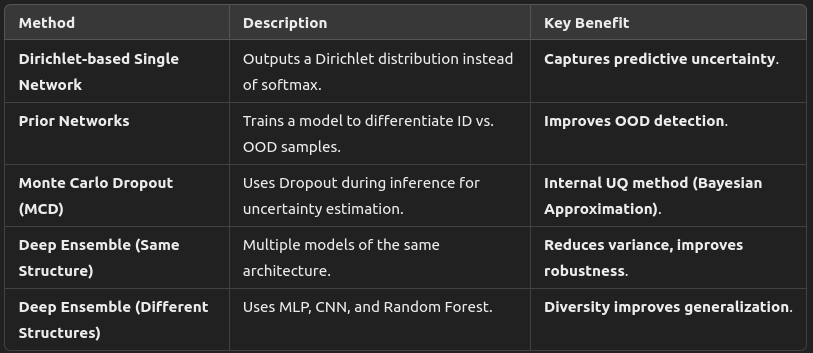

Now that we have trained standard classifiers (SVM, Random Forest), we will apply Uncertainty Quantification (UQ) methods: